<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/master/session3/hillenbrand-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/master/session3/hillenbrand-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Machine Learning using using scikit-learn with the Hillenbrand database

### PART II:  RECOGNIZE a VOWEL FROM FORMANT MEASUREMENTS

### 1. Setting up your Python Environment
 
1. Import Python's Machine Learning Stack

2. Import needed local utilities that are needed for this exercise

In [1]:
# Importing Python's baseline machine learning stack 
#
% matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/spchlab.git
except:
  IN_COLAB = False

from spchutils.hildata import fetch_hillenbrand

  Cloning https://github.com/compi1234/spchlab.git to /tmp/pip-req-build-90k9ujb_
  Running command git clone -q https://github.com/compi1234/spchlab.git /tmp/pip-req-build-90k9ujb_
  Created wheel for spchlab: filename=spchlab-0.1.0-cp36-none-any.whl size=22533 sha256=1d56e03785d2fd4eebcce081484d17fc08ad827bc4b09eac9ee7810858a3b16a
  Stored in directory: /tmp/pip-ephem-wheel-cache-herskm69/wheels/7c/9f/61/13c54821558a768884d966e08cccd30e00e66a4fc6924bf73b
Successfully built spchlab


### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: http://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt

In [2]:
# you can grap a  subset of 6 or 3 vowels by specifying 'vowels6' or 'vowels3', default is 'all'
# Hillenbrand dataset contains records with missing data
# we drop all records with missing (NA) variables with .dropna()
hildata = fetch_hillenbrand(genders='adults',vowels='all',columns=["vid","dur","f0","F1","F2","F3"]).dropna()
hildata.rename(columns={'vid':'vowel'},inplace=True)

print(hildata.head())
#print(hildata.columns, hildata.index)

  vowel    dur     f0     F1      F2      F3
0    ae  323.0  174.0  663.0  2012.0  2659.0
1    ae  250.0  102.0  628.0  1871.0  2477.0
2    ae  344.0   99.0  605.0  1812.0  2570.0
3    ae  312.0  124.0  627.0  1910.0  2488.0
4    ae  254.0  115.0  647.0  1864.0  2561.0


### 3. Data Exploration

In this task we have multiple features that can be used to make our classififier better.
First task is to decide which ones to use.

Scatter plots may give us an insight as to which features are most relevant.
We can make a simple scatter plot with 2 preselected features, or can have a conglomerate of scatter plots for a getter overview

##### Tasks & Questions (1)
1. What do the scatter plots tell you.  Are there features that must be retained or others that can surely be dropped ?

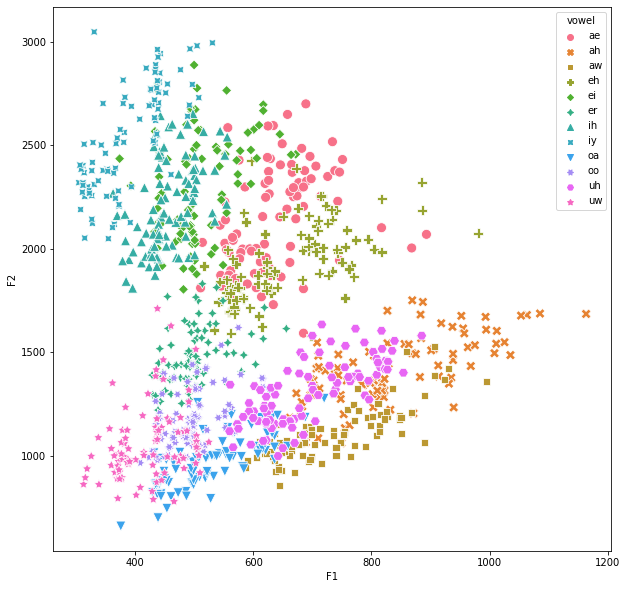

In [3]:
# a simple scatter plot with 2 selected features
# the categgories can be shown as hue(color) or style(marker)
f=plt.figure(figsize=(10,10))
sns.scatterplot(x='F1',y='F2',data=hildata,hue="vowel",style="vowel",s=100)

<Figure size 720x720 with 0 Axes>

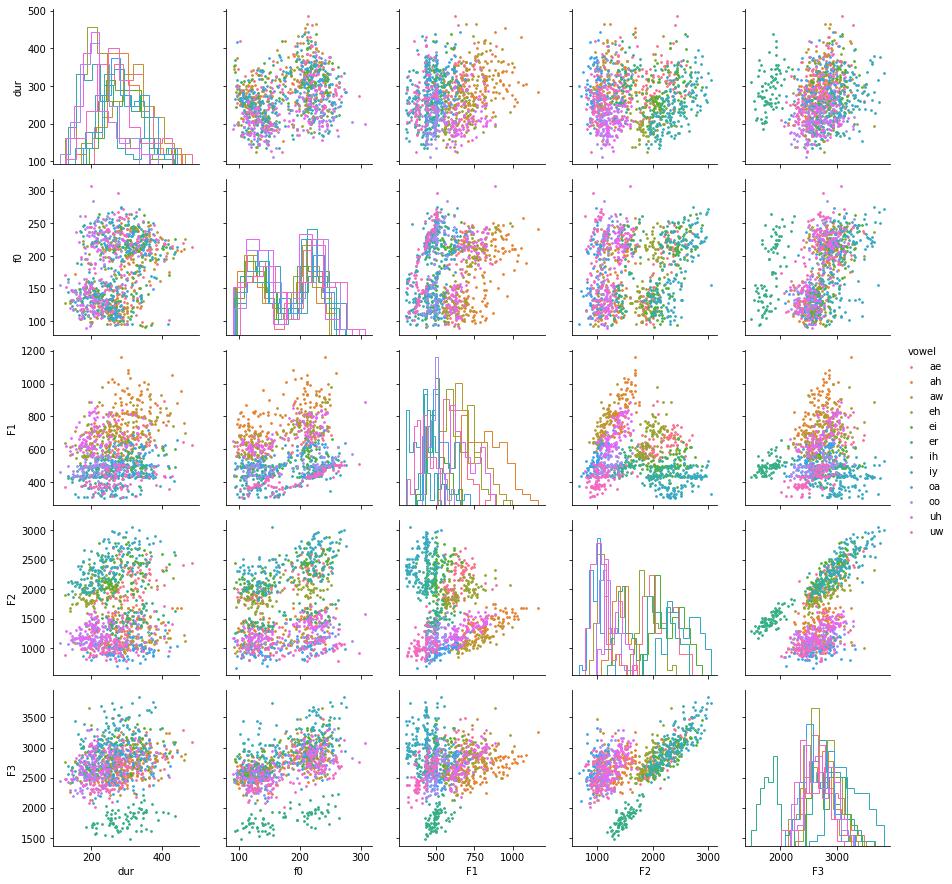

In [4]:
# if we want to see multiple scatter plots for the same data, we can first construct a grid over
# which we will make the plots
f=plt.figure(figsize=(10,10))
g = sns.PairGrid(hildata,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=3)
g.add_legend()

In [5]:
# We will use F1, F2 and F3 (and optionally 'dur') data in the classification experiments
#   later usage   
#       X[:,0:1] gives F1 + F2
#       X[:,0:2] gives F1 + F2 + F3
#       X        gives F1 + F2 +F3 + dur
#
X=np.array(hildata.loc[:,['F1','F2','F3','dur']])
y=np.array(hildata.loc[:,'vowel'])
classes = np.unique(y)

### 4. Classification using a Bayesian classifier and Gaussian models

We know now enough to create and test our classifier
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train models in each class given the training data 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

For this, we will use the class *GaussianMixtureClass* which is provided in *spchutils* .
It is implemented as an extension to *sklearn*, making use of the sklearn GaussianMixture density estimator, as we used before. 

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian MM
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   
- random_state:  you can modify this to have a different division between train and test sets and see if you get different results


##### Task & Questions (3)
1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
3. (optional) Go back and use a smaller database, just selecting the short vowels with 'vowels6' and do the same analysis
4. (optional) Go back and add 'dur' as a 4th feature.  Duration is temporal feature and could be complementary to the formants that are spectral features.  Where in the confusion matrix could you hope for an improvement ? 

In [6]:
from spchutils.GaussianMixtureClf import GaussianMixtureClf
# --------------
n_components = 1
train_size=0.5
max_iter = 10      # maximum number of iterations in the EM algorithm
random_state=0     # sets initialization of RNG for selecting train/test data, set to None to be random
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:3],y,test_size=test_size, random_state=random_state)
clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=max_iter)
clf_GM.fit(X_train,y_train)
# 2. print the model
clf_GM.print()
#print("Classes: ",clGM.classes_)
y_pred = clf_GM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (ae) with prior=0.077
-----------------------------------
[1.] [[ 640.04761905 2111.5952381  2760.07142857]] [[ 76.92883304 229.09293805 238.00584155]]
Class[1] (ah) with prior=0.090
-----------------------------------
[1.] [[ 841.18367347 1416.91836735 2681.48979592]] [[114.23314389 162.36841916 179.22533104]]
Class[2] (aw) with prior=0.075
-----------------------------------
[1.] [[ 714.26829268 1077.31707317 2620.82926829]] [[ 97.60348465 116.23618492 243.43726617]]
Class[3] (eh) with prior=0.075
-----------------------------------
[1.] [[ 667.36585366 1969.65853659 2818.14634146]] [[100.66916502 167.42331478 217.27913496]]
Class[4] (ei) with prior=0.081
-----------------------------------
[1.] [[ 503.84090909 2292.88636364 2861.36363636]] [[ 60.16150355 255.96308469 250.27367665]]
Class[5] (er) with prior=0.066
-----------------------------------
[1.] [[ 514.5        1528.33333333 1888.05555556]] [[ 50.36174696 155.85089028 159.99321938]]
Class[6] (ih) with prior=0.099
---

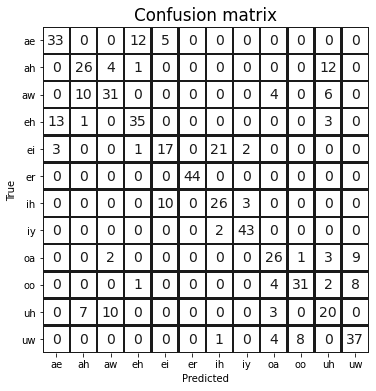

Accuracy: 67.71%


In [7]:
# A Confusion Matrix gives a more detailed image of the errors that we make
# The routine makes for pretty printing
def plot_confusion_matrix(cm,labels=[],cmap=[]):
    import seaborn as sns

    if len(labels) == 0:
        df_cm = pd.DataFrame(cm)
    else:
        df_cm = pd.DataFrame(cm, labels, labels)
        
    f,ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"fontsize": 14,"color":'k'},
                square=True,linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    # font size
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_pred = clf_GM.predict(X_test)
cmat = skmetrics.confusion_matrix(y_test,y_pred)
#print('Confusion Matrix:\n',cmat)    
    
plot_confusion_matrix(cmat,labels=classes)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

##### Task & Questions (4)
Given this rather limited database, we may prefer a cross_validation style evaluation

1. Evaluate the performance for different settings in n_components (number of gaussians) 1,2,4,8 . Is there a need to change max_iter, the maximum number of iterations for EM
2. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
   use X for all features X[:,0:2] for features F1 and F2  or X[:,i] for a single feature with i for feature 0..2  or also [:,[0,1,3]] for a combination of F1,F2 and duration 
3. Change the number of folds in the crossvalidation between 2,5 and 10.  What do you observe?
what does it tell you about the size of the database ?
4. (optional) Go back and use a smaller (easier) database, just selecting the short vowels with 'vowels6' and do the same analysis


In [8]:
nfolds = 10
Xselect = X[:,[0,1]]
n_components = 1
clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=20)
scores = cross_val_score(clf_GM, Xselect, y, cv=nfolds)
print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

Average Cross validation score for 10 folds: 60.18 % correct
